In [ ]:
import torch

from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, Linear, ReLU, Tanh, CrossEntropyLoss, Flatten
from torch.optim import Adam

from time import time
from math import floor
import matplotlib.pyplot as plt

In [ ]:
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,)),
    # flatten
    Lambda(lambda x: x.view(-1))
])

train = MNIST(root='data_mnist', train=True, download=True, transform=transform)
test = MNIST(root='data_mnist', train=False, download=True, transform=transform)

In [3]:
print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data_mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data_mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )


In [ ]:
train.data[0].shape

torch.Size([28, 28])

In [5]:
train.targets[0]

tensor(5)

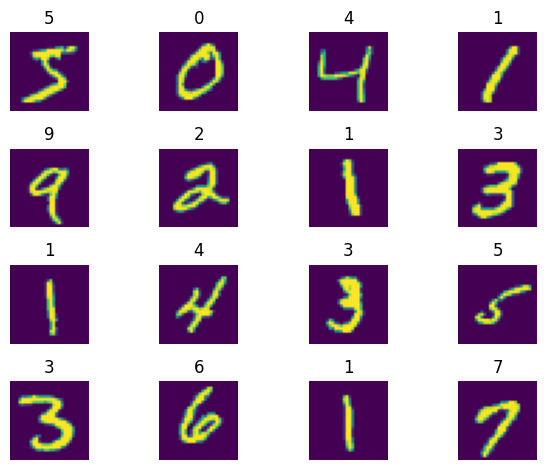

In [6]:
for idx, image in enumerate(train.data[:16]):
    plt.subplot(4, 4, idx+1)
    plt.imshow(image)
    plt.title(train.targets[idx].item())
    plt.axis("off")
    
plt.tight_layout()

In [7]:
batch_size = 128
trainset = DataLoader(train, batch_size=128, shuffle=True)
testset = DataLoader(test, batch_size=128, shuffle=True)

In [ ]:
class AutoEncoder(Module):
    def __init__(self):
        super().__init__()

        input_size = 28 * 28
        latent_space = 64

        self.encoder = Sequential(
            Flatten(),
            Linear(input_size, 512),
            ReLU(),
            Linear(512, 256),
            ReLU(),
            Linear(256, latent_space),
            ReLU()
        )

        self.decoder = Sequential(
            Linear(latent_space, 256),
            ReLU(),
            Linear(256, 512),
            ReLU(),
            Linear(512, input_size),
            Tanh()
        )

        # 분류 (CrossEntropyLoss 에 Softmax 추가되어 있음)
        self.classifier = Linear(latent_space, 10)
    
    def forward(self, x):
        latent_vector = self.encoder(x)
        # classification
        logits = self.classifier(latent_vector)
        return logits
    

In [9]:
model = AutoEncoder()

In [ ]:
learning_rate = 0.001

# classification 이므로 crossentropy 사용
loss_function = CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 20

total_time = list()
for epoch in range(epochs):
    now = time()
    avg_loss = 0.0

    for i, data in enumerate(trainset):
        # 지도학습
        x_train, y_train = data

        optimizer.zero_grad()

        h = model(x_train)
        
        # 지도학습
        loss = loss_function(h, y_train)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    
    learning_time = int(time() - now)
    total_time.append(learning_time)

    print(f"epoch: {epoch+1:3d}/{epochs} \t Loss: {avg_loss/len(trainset):.3f} \t {learning_time}s")

print(f"learning time ({epochs} epoch) : {floor(sum(total_time) / 60)}m {sum(total_time) % 60}")

epoch : (1) 	 Loss: 0.384 	 9s
epoch : (2) 	 Loss: 0.160 	 10s
epoch : (3) 	 Loss: 0.115 	 12s
epoch : (4) 	 Loss: 0.090 	 12s
epoch : (5) 	 Loss: 0.075 	 12s
epoch : (6) 	 Loss: 0.065 	 13s
epoch : (7) 	 Loss: 0.059 	 13s
epoch : (8) 	 Loss: 0.050 	 13s
epoch : (9) 	 Loss: 0.046 	 10s
epoch : (10) 	 Loss: 0.041 	 9s
epoch : (11) 	 Loss: 0.037 	 11s
epoch : (12) 	 Loss: 0.033 	 12s
epoch : (13) 	 Loss: 0.032 	 12s
epoch : (14) 	 Loss: 0.026 	 13s
epoch : (15) 	 Loss: 0.026 	 13s
epoch : (16) 	 Loss: 0.027 	 13s
epoch : (17) 	 Loss: 0.027 	 13s
epoch : (18) 	 Loss: 0.025 	 13s
epoch : (19) 	 Loss: 0.022 	 13s
epoch : (20) 	 Loss: 0.018 	 13s
learning time (20 epoch) : 3m 59


In [ ]:
test_iter = iter(testset)
x_test, y_test = next(test_iter)

In [13]:
predict = model(x_test)
_, predict_labels = torch.max(predict, 1)

print(predict_labels)
print(y_test)

tensor([0, 3, 5, 5, 6, 2, 6, 5, 3, 5, 7, 2, 3, 5, 8, 8, 3, 0, 0, 6, 8, 9, 5, 1,
        8, 1, 9, 6, 9, 3, 5, 9, 9, 1, 3, 5, 9, 7, 1, 1, 0, 3, 0, 5, 6, 4, 9, 1,
        2, 2, 0, 7, 5, 2, 0, 8, 5, 7, 6, 8, 5, 0, 0, 9, 0, 3, 1, 9, 6, 6, 6, 8,
        7, 6, 9, 7, 9, 7, 7, 7, 1, 1, 5, 3, 2, 5, 1, 8, 0, 8, 6, 6, 1, 6, 3, 1,
        0, 3, 5, 9, 9, 2, 2, 8, 9, 0, 0, 7, 2, 0, 7, 5, 7, 1, 2, 6, 6, 4, 8, 9,
        5, 2, 6, 6, 4, 2, 4, 2])
tensor([0, 5, 5, 5, 6, 2, 6, 5, 3, 5, 7, 2, 3, 5, 8, 8, 3, 0, 0, 6, 8, 9, 5, 1,
        8, 1, 9, 6, 9, 3, 5, 9, 9, 1, 3, 5, 9, 7, 1, 1, 0, 3, 0, 5, 6, 4, 9, 1,
        2, 2, 0, 7, 5, 2, 0, 8, 5, 7, 6, 8, 5, 0, 0, 9, 0, 3, 1, 9, 6, 6, 6, 8,
        7, 6, 9, 7, 9, 7, 7, 7, 1, 1, 5, 3, 2, 5, 1, 8, 0, 8, 6, 6, 1, 6, 3, 1,
        0, 3, 5, 9, 9, 2, 2, 8, 9, 0, 0, 7, 2, 0, 7, 5, 7, 1, 2, 6, 6, 4, 8, 9,
        5, 2, 6, 6, 4, 2, 4, 2])


In [ ]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in testset:
        x_test, y_test = data
        h = model(x_test)
        _, predicted = torch.max(h.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

print(f'acc : {100 * correct / total:.2f}%')

acc : 97 %
